shape of class 0
(5923, 784)
shape of class 1
(6742, 784)
shape of class 2
(5958, 784)
(784, 18623)
shape of Y_train (10, 18623)
shape of Y_train_label (18623,)
shape of class 0
(980, 784)
shape of class 1
(1135, 784)
shape of class 2
(1032, 784)
(784, 3147)
shape of Y_test (10, 3147)
shape of Y_test_label (3147,)
Train performance
train size (18623, 10)
True preds 16890
Class wise accuracy for trained data:
Class 0 : 91.44014857335809 %
Class 1 : 94.09670720854346 %
Class 2 : 86.10271903323263 %
Overall Accuracy for trained data 90.69430274391881 %
Test performance
test size (3147, 10)
True preds 2567
Class wise accuracy for test data:
Class 0 : 94.28571428571428 %
Class 1 : 71.36563876651982 %
Class 2 : 80.71705426356588 %
Overall Accuracy for test data 81.56974896727041 %


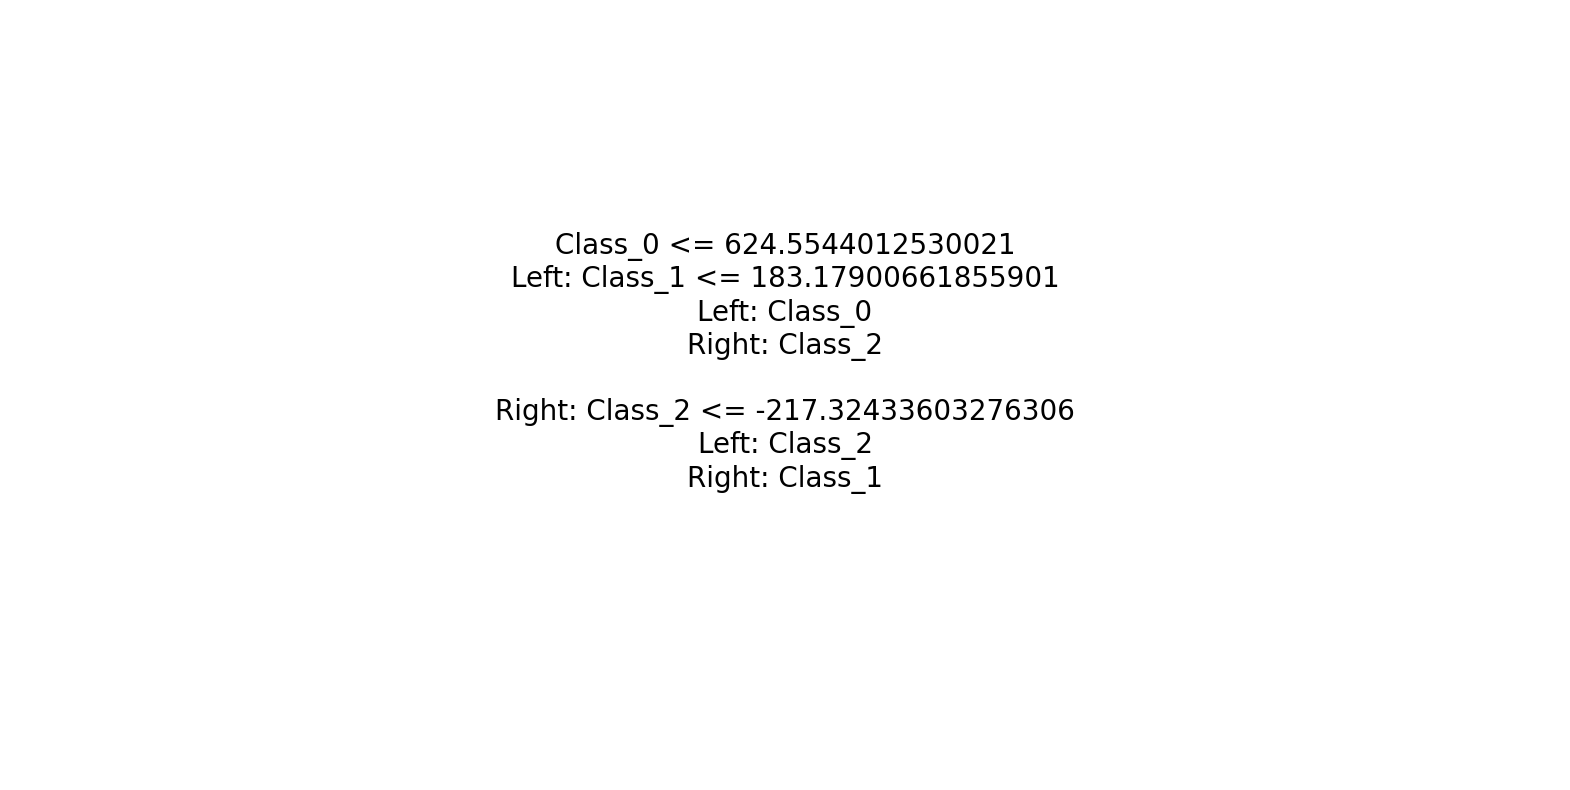

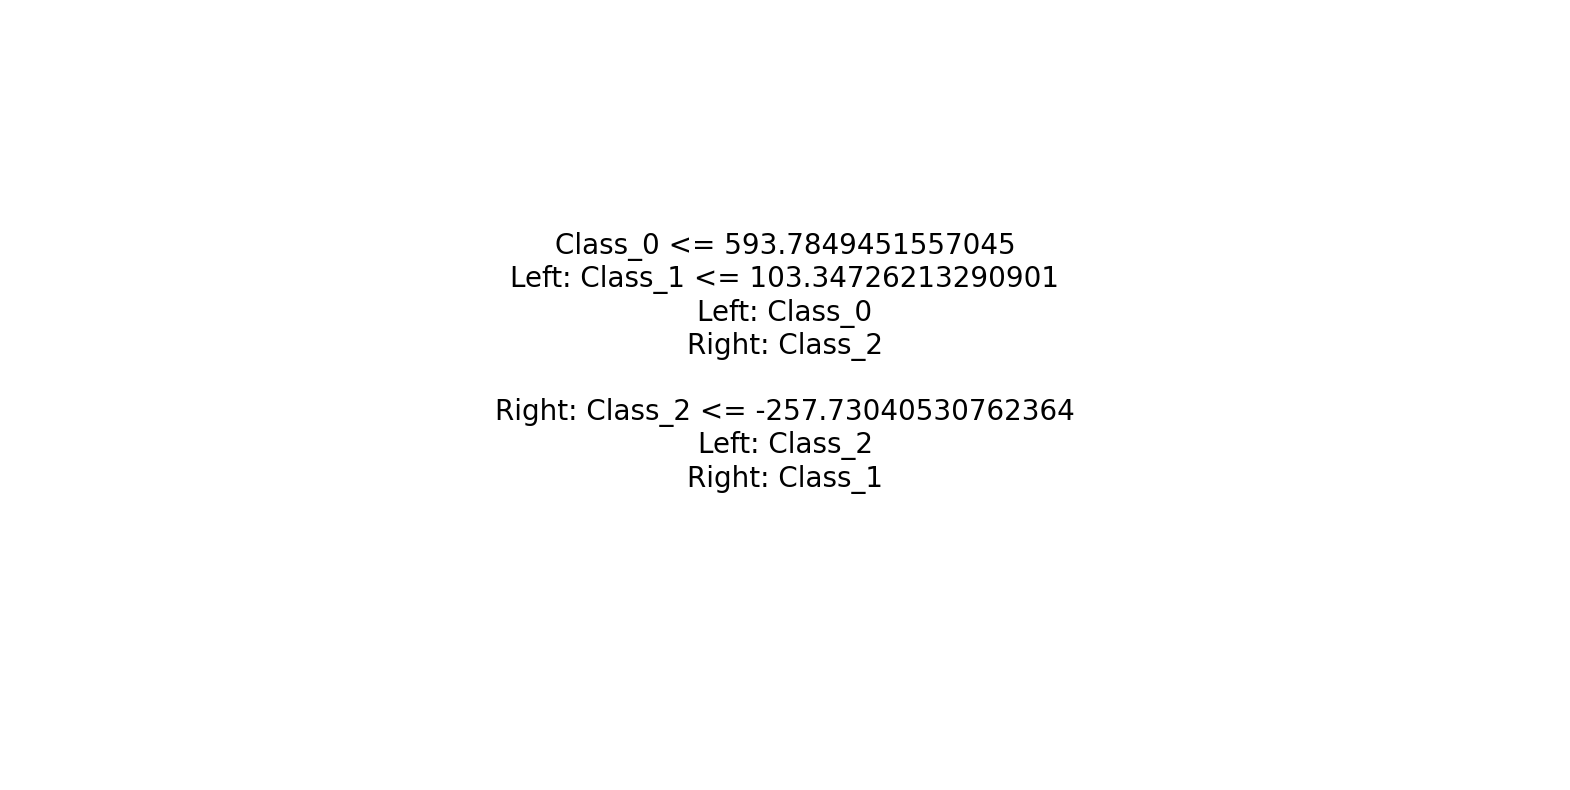

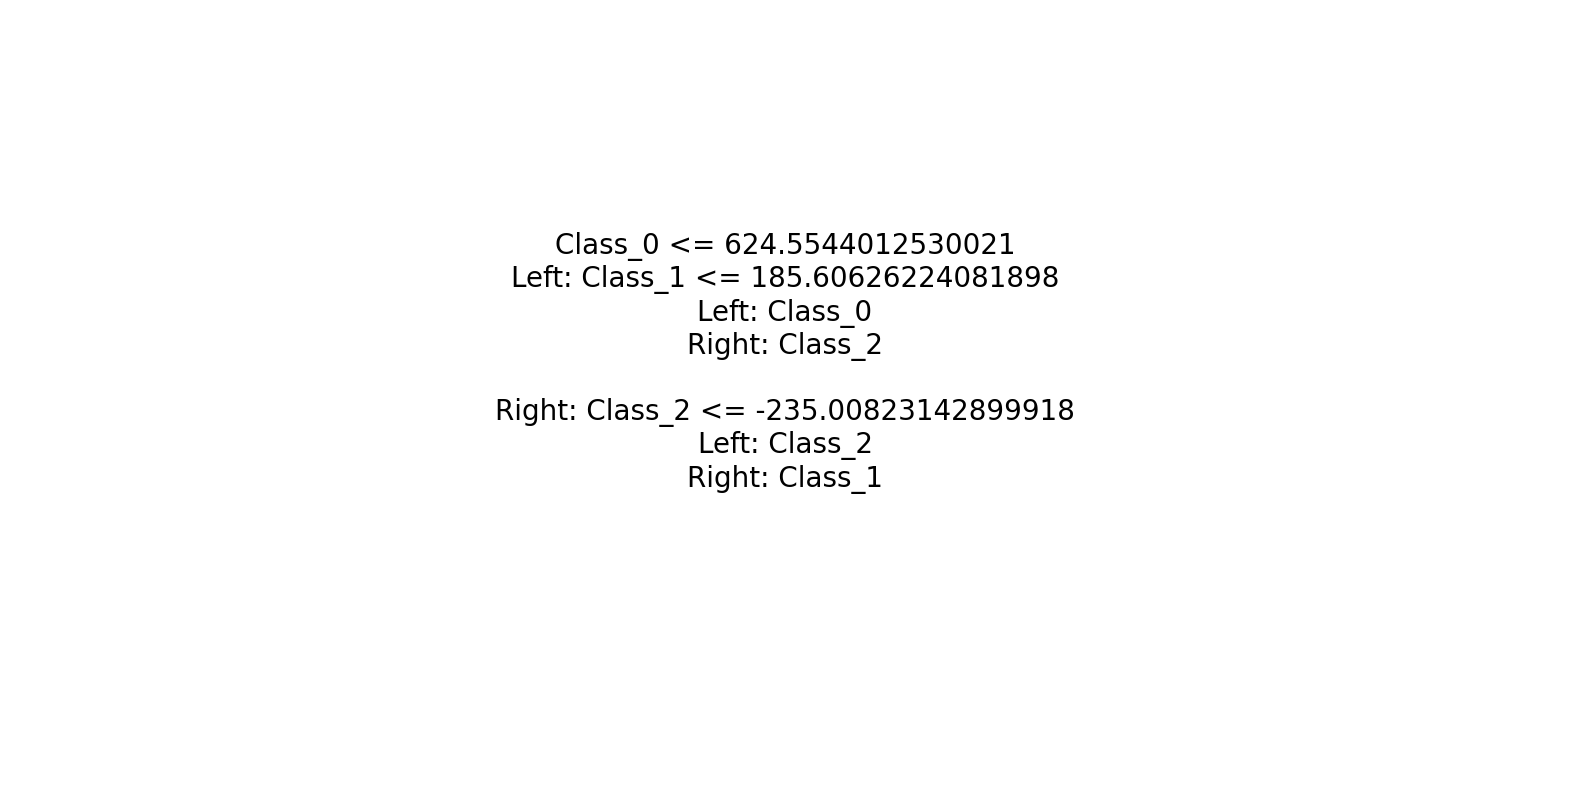

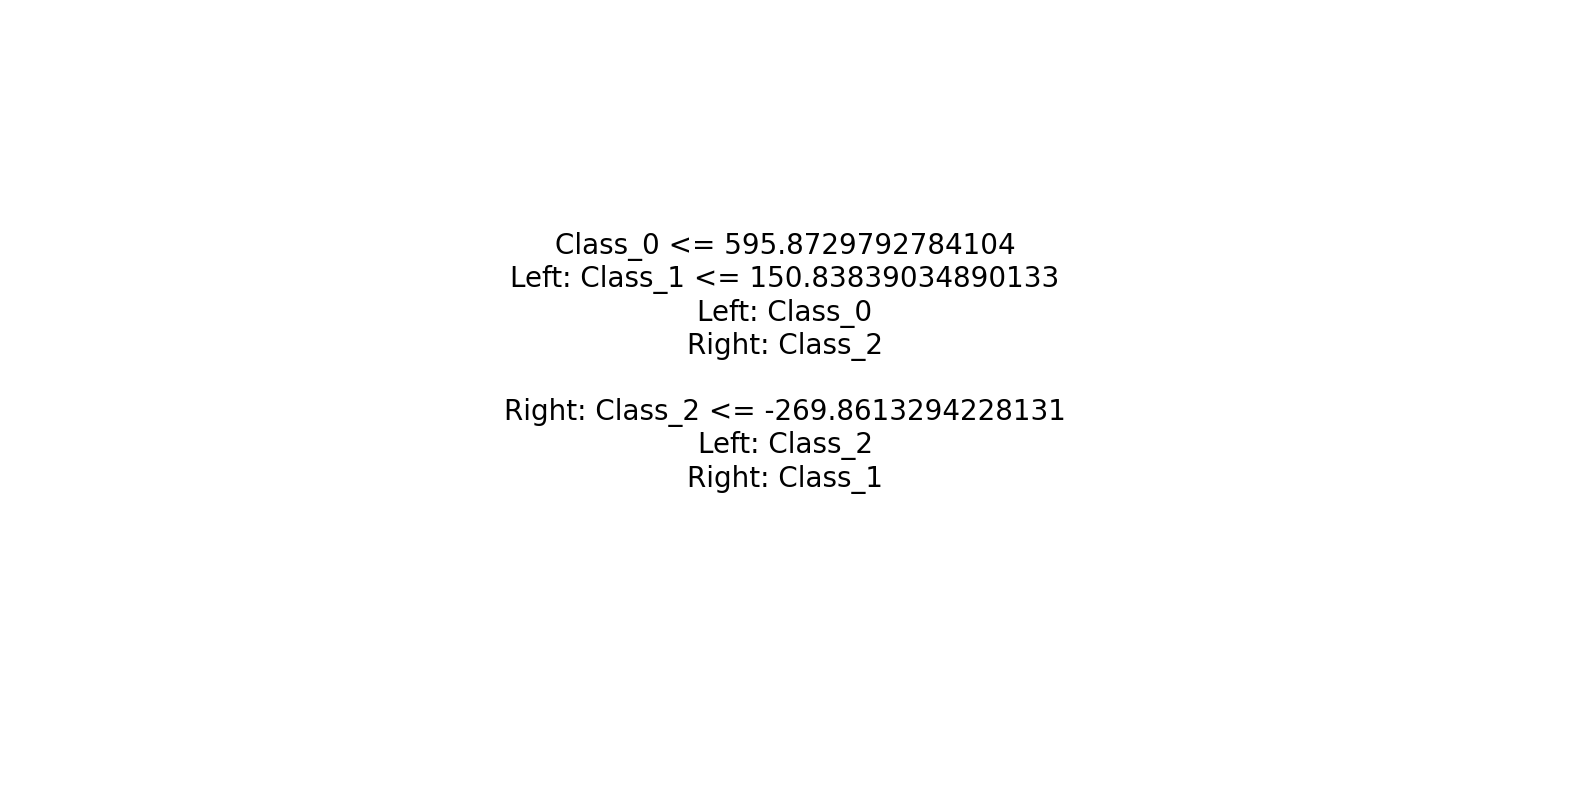

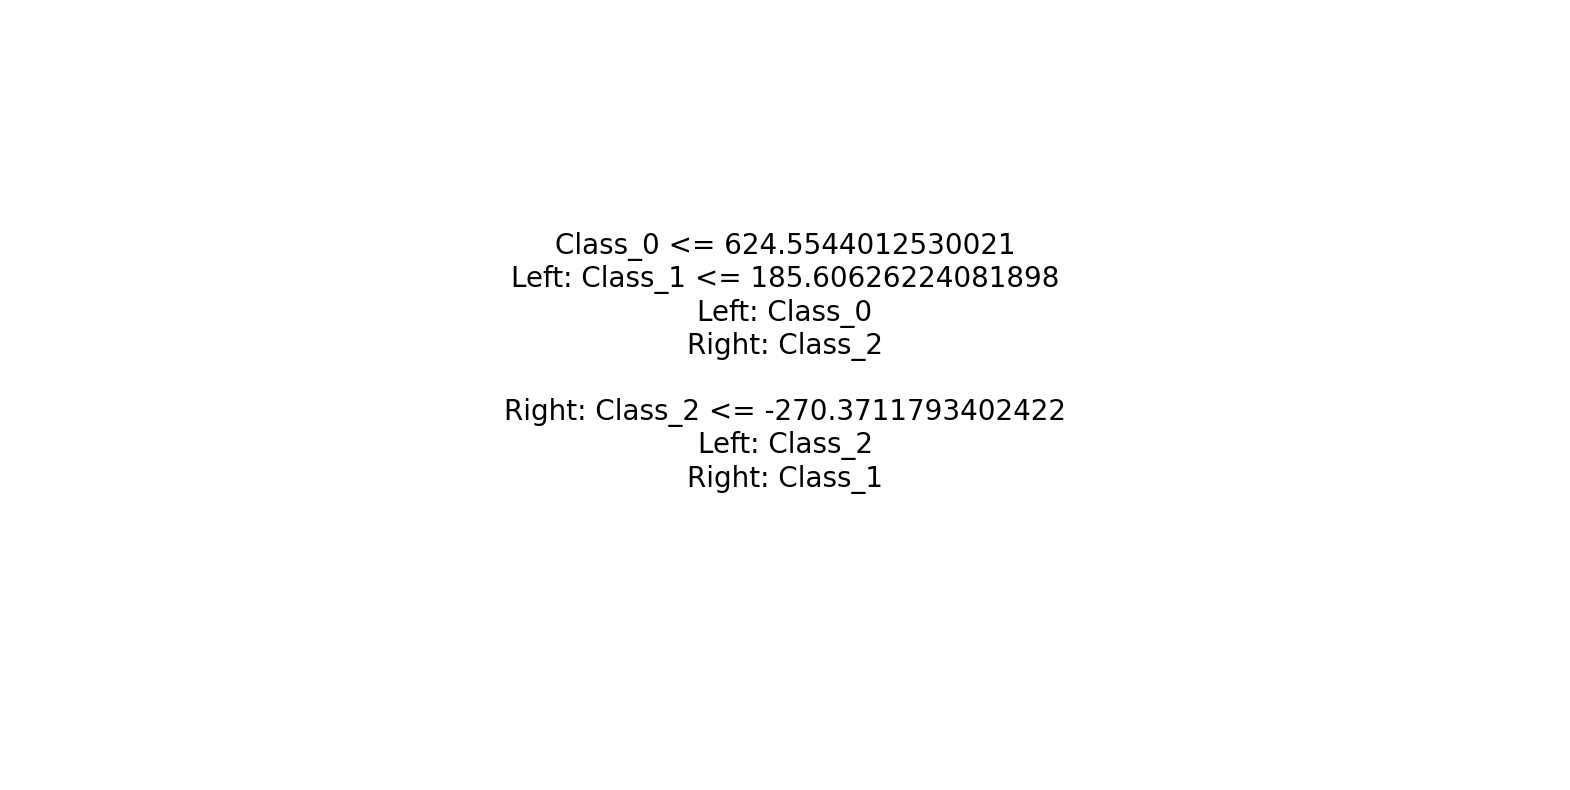

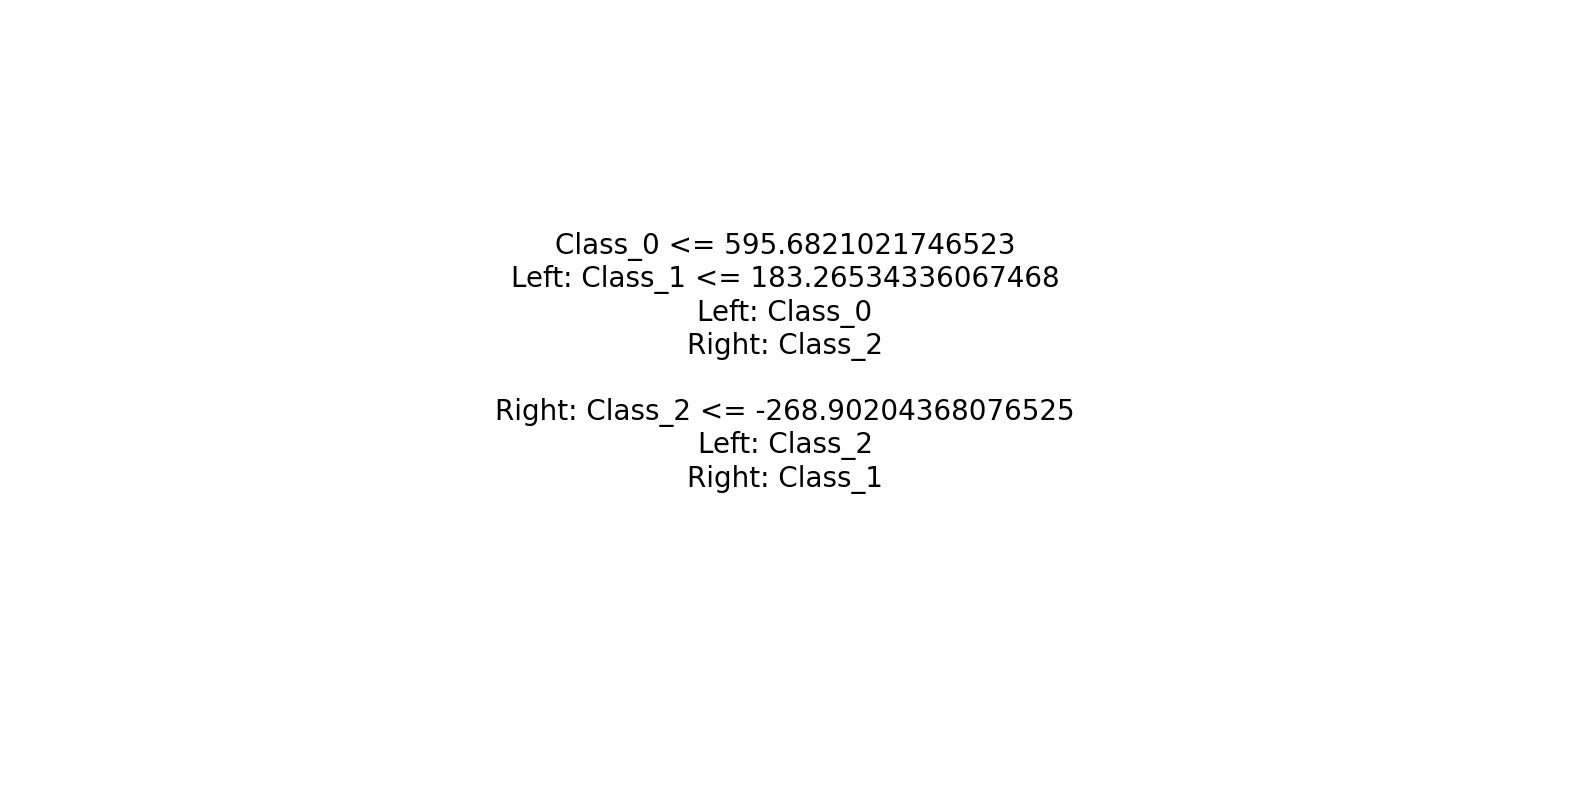

Total Accuracy for train: 91.0809214412286 %
Class 0 Accuracy for train: 91.44014857335809 %
Class 1 Accuracy for train: 95.46128745179472 %
Class 2 Accuracy for train: 85.76703591809331 %
Total Accuracy for test: 84.58849698125198 %
Class 0 Accuracy for test: 94.28571428571428 %
Class 1 Accuracy for test: 80.26431718061674 %
Class 2 Accuracy for test: 80.13565891472868 %


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.tree import plot_tree
from sklearn.utils import resample

class mnistPCA:
    def __init__(self, train, train_label, class_matrix, count):
        self.train = train
        self.train_label = train_label
        self.class_matrix = class_matrix
        self.count = count

        # Separate images by class
        for i in range(3):
            vector = []
            for j in range(len(train)):
                self.count[i] += 1 if train_label[j] == i else 0
                if train_label[j] == i:
                    vector.append(train[j])
            self.class_matrix.append(vector)

        # Convert class matrices to numpy arrays
        for i in range(3):
            self.class_matrix[i] = np.array(self.class_matrix[i])
        count = np.array(self.count)

        for i in range(3):
            print("shape of class",i)
            print(self.class_matrix[i].shape)

        # making the data matrix
        self.X = []
        for i in range(len(self.class_matrix)):
            for j in range(count[i]):
                self.X.append(self.class_matrix[i][j])
        self.X = np.array(self.X)
        self.X = self.X.T


        self.X_mean = np.mean(self.X, axis=1).reshape(784, 1)

        # remove mean from the data
        self.X = self.X - self.X_mean
        print(self.X.shape)

        # use PCA on centralised data
        self.cov_X = np.dot(self.X, self.X.T) / sum(count) - 1

        self.eigen_values, self.eigen_vectors = np.linalg.eig(self.cov_X)
        self.eigen_values = np.real(self.eigen_values)
        self.eigen_vectors = np.real(self.eigen_vectors)

        # sort the eigen values in descending order, and eigen vectors accordingly
        idx = self.eigen_values.argsort()[::-1]
        self.eigen_values = self.eigen_values[idx]
        self.eigen_vectors = self.eigen_vectors[:, idx]

        # making the U matrix
        self.U = []
        for i in range(len(self.eigen_values)):
            self.U.append(self.eigen_vectors[:, :i+1])

    def reduceDim(self, eigen):
        U_p = self.U[eigen - 1]

        # Y = U_p.T * X
        Y = np.dot(U_p.T, self.X)

        Y_label = np.zeros(sum(self.count), dtype=int)

        for i in range(len(self.class_matrix)):
            for j in range(self.count[i]):
                Y_label[sum(self.count[:i]) + j] = i

        return Y, Y_label

class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        if np.isscalar(X):
            X = np.array([X])
        return [self._predict(inputs) for inputs in X]

    def _best_split(self, X, y):
        m = y.size
        if m <= 1:
            return None, None
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)  # 1 - (probab)**2
        best_idx, best_thr = None, None

        for idx in range(self.n_features_):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1

                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )
                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:  # two equal thresholds cannot be in different leaves
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(predicted_class=predicted_class)

        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    # def _gini_impurity(self, y):
    #     m = y.size
    #     return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in range(self.n_classes_))

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

# class random_forest_classifier:
#     def __init__(self, max_depth=None):
#         self.max_depth = max_depth

#     def fit(self, X, y):
#         self.n_classes_ = len(set(y))
#         self.n_features_ = X.shape[1]
#         self.trees = []
#         for _ in range(5):
#             sampled_X, sampled_y = resample(X, y, replace=True)
#             tree = DecisionTreeClassifier(max_depth=self.max_depth)
#             tree.fit(sampled_X, sampled_y)
#             self.trees.append(tree)

#     def predict(self, X):
#         return [self._predict_f(inputs) for inputs in X]

#     def _predict_f(self, inputs):
#         preds = np.array([tree.predict(input) for input in inputs for tree in self.trees])
#         final_preds = []
#         for i in range(len(preds[0])):
#             unique_classes, class_counts = np.unique(preds[:, i], return_counts=True)
#             max_count = np.max(class_counts)
#             max_classes = unique_classes[class_counts == max_count]
#             if len(max_classes) == 1 or max_count >= 3:
#                 final_preds.append(max_classes[0])
#             else:
#                 final_preds.append(max_classes[0])  # Choose any class if tie
#         return final_preds

# visulaising the decision tree
def convert_tree_to_sklearn(node, feature_names, class_names):
    if node is None:
        return None

    if node.left is None and node.right is None:
        # Leaf node
        class_name = class_names[node.predicted_class]
        return class_name

    feature_name = feature_names[node.feature_index]
    threshold = node.threshold

    left_child = convert_tree_to_sklearn(node.left, feature_names, class_names)
    right_child = convert_tree_to_sklearn(node.right, feature_names, class_names)

    tree_node = f"{feature_name} <= {threshold}\n"
    tree_node += f"Left: {left_child}\n"
    tree_node += f"Right: {right_child}\n"

    return tree_node

def visualize_decision_tree(tree, feature_names, class_names):
    sklearn_tree = convert_tree_to_sklearn(tree.tree_, feature_names, class_names)
    plt.figure(figsize=(20, 10))
    plt.text(0.5, 0.5, sklearn_tree, size=20, ha="center", va="center")
    plt.axis('off')
    plt.show()


def main():
    # data = np.load('mnist.npz')
    data = np.load(tf.keras.utils.get_file('mnist.npz', 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'))

    train = data['x_train']
    train_label = data['y_train']
    test = data['x_test']
    test_label = data['y_test']

    train = train.reshape(len(train), 784)
    test = test.reshape(len(test), 784)

    train = -1 * train

    # Initialize matrices and counts for each class
    class_matrix = []
    count = np.zeros(3, dtype=int)

    pca = mnistPCA(train, train_label, class_matrix, count)

    # returns the reduced dimension data and the labels
    Y, Y_label = pca.reduceDim(10)
    print("shape of Y_train", Y.shape)
    print("shape of Y_train_label", Y_label.shape)

#------------------------------------------------------------------------------------------------------
    # Initialize matrices and counts for each class
    class_matrix_test = []
    count_test = np.zeros(3, dtype=int)

    pca_test = mnistPCA(test, test_label, class_matrix_test, count_test)

    # returns the reduced dimension data and the labels
    Y_test, Y_test_label = pca_test.reduceDim(10)
    print("shape of Y_test", Y_test.shape)
    print("shape of Y_test_label", Y_test_label.shape)

#-------------------------------------------------------------------------------------------------------
    # Decision Tree
    tree = DecisionTreeClassifier(max_depth=2)
    tree.fit(Y.T, Y_label)

    # tree.print_tree()

    # train performance
    train_preds = tree.predict(Y.T)
    print("Train performance")
    print("train size", Y.T.shape)
    print("True preds", sum(train_preds == Y_label))
    print("Class wise accuracy for trained data:")
    class_wise = [0, 0, 0]
    for i in range(len(Y_label)):
        if (train_preds[i] == Y_label[i]):
            class_wise[Y_label[i]] += 1

    for i in range(3):
        print("Class", i, ":", class_wise[i] / sum(Y_label == i) * 100, "%")

    print("Overall Accuracy for trained data", sum(train_preds == Y_label) / len(Y_label) * 100, "%")

    # test performance
    test_preds = tree.predict(Y_test.T)
    print("Test performance")
    print("test size", Y_test.T.shape)
    print("True preds", sum(test_preds == Y_test_label))
    print("Class wise accuracy for test data:")
    class_wise = [0, 0, 0]
    for i in range(len(Y_test_label)):
        if (test_preds[i] == Y_test_label[i]):
            class_wise[Y_test_label[i]] += 1

    for i in range(3):
        print("Class", i, ":", class_wise[i] / sum(Y_test_label == i) * 100, "%")

    print("Overall Accuracy for test data", sum(test_preds == Y_test_label) / len(Y_test_label) * 100, "%")

    #print(plot_tree(tree, Y.T, Y_label))
    class_names = [f'Class_{i}' for i in range(tree.n_classes_)]
    feature_names = [f'Class_{i}' for i in range(Y.shape[1])]

    visualize_decision_tree(tree, feature_names, class_names)

# ------------------------------------------------------------------------------------------------------

    # Initialize class names
    class_names = [f'Class_{i}' for i in range(3)]

    # Bagging and training 5 decision trees
    trees = []
    for _ in range(5):
        # Sample training data with replacement
        sampled_Y, sampled_Y_label = resample(Y.T, Y_label, replace=True)

        class_names = [f'Class_{i}' for i in range(3)]
        feature_names = [f'Class_{i}' for i in range(Y.shape[1])]

        # Train decision tree
        tree = DecisionTreeClassifier(max_depth=2)
        tree.fit(sampled_Y, sampled_Y_label)
        visualize_decision_tree(tree, feature_names, class_names)
        trees.append(tree)

    # Test performance
    # for train samples
    train_preds = np.array([tree.predict(Y.T) for tree in trees])
    final_preds_train = []
    for i in range(len(train_preds[0])):
        unique_classes, class_counts = np.unique(train_preds[:, i], return_counts=True)
        max_count = np.max(class_counts)
        max_classes = unique_classes[class_counts == max_count]
        if len(max_classes) == 1 or max_count >= 3:
            final_preds_train.append(max_classes[0])
        else:
            final_preds_train.append(max_classes[0])  # Choose any class if tie

    final_preds_train = np.array(final_preds_train)
    print("Total Accuracy for train:", sum(final_preds_train == Y_label) / len(Y_label) * 100, "%")

    # Class-wise accuracy
    for i in range(3):
        indices = (Y_label == i)
        class_accuracy = sum(final_preds_train[indices] == Y_label[indices]) / sum(indices)
        print(f"Class {i} Accuracy for train:", class_accuracy * 100, "%")

    test_preds = np.array([tree.predict(Y_test.T) for tree in trees])
    final_preds = []
    for i in range(len(test_preds[0])):
        unique_classes, class_counts = np.unique(test_preds[:, i], return_counts=True)
        max_count = np.max(class_counts)
        max_classes = unique_classes[class_counts == max_count]
        if len(max_classes) == 1 or max_count >= 3:
            final_preds.append(max_classes[0])
        else:
            final_preds.append(max_classes[0])  # Choose any class if tie

    final_preds = np.array(final_preds)
    print("Total Accuracy for test:", sum(final_preds == Y_test_label) / len(Y_test_label) * 100, "%")

    # Class-wise accuracy
    for i in range(3):
        indices = (Y_test_label == i)
        class_accuracy = sum(final_preds[indices] == Y_test_label[indices]) / sum(indices)
        print(f"Class {i} Accuracy for test:", class_accuracy * 100, "%")

    # # Random forest
    # rf = random_forest_classifier(max_depth=2)
    # rf.fit(Y.T, Y_label)

    # # train performance
    # train_preds = rf.predict(Y.T)
    # print("Train performance")
    # print("train size", Y.T.shape)
    # print("True preds", sum(train_preds == Y_label))
    # print("Class wise accuracy for trained data:")
    # class_wise = [0, 0, 0]
    # for i in range(len(Y_label)):
    #     if (train_preds[i] == Y_label[i]):
    #         class_wise[Y_label[i]] += 1

    # for i in range(3):
    #     print("Class", i, ":", class_wise[i] / sum(Y_label == i), "%")

    # print("Overall Accuracy for trained data", sum(train_preds == Y_label) / len(Y_label), "%")

    # # test performance
    # test_preds = rf.predict(Y_test.T)
    # print("Test performance")
    # print("test size", Y_test.T.shape)
    # print("True preds", sum(test_preds == Y_test_label))
    # print("Class wise accuracy for test data:")
    # class_wise = [0, 0, 0]
    # for i in range(len(Y_test_label)):
    #     if (test_preds[i] == Y_test_label[i]):
    #         class_wise[Y_test_label[i]] += 1

    # for i in range(3):
    #     print("Class", i, ":", class_wise[i] / sum(Y_test_label == i), "%")

    # print("Overall Accuracy for test data", sum(test_preds == Y_test_label) / len(Y_test_label), "%")

if __name__ == "__main__":
    main()


# References
## https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775
## https://www.analyticsvidhya.com/blog/2020/10/all-about-decision-tree-from-scratch-with-python-implementation/